In [87]:
# Import all dependencies
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import math
np.math = math
np.int= int
np.float= float

import matplotlib.pyplot as plt

from dragonfly import minimise_function
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, LSTM, Bidirectional, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras_tuner as kt
#from kerastuner import RandomSearch
#from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
#For Hyperparameters tuning
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras.models import save_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load the data

In [88]:
file_path= os.path.join('..', 'cleaned_data', 'new_data.csv')
data = pd.read_csv(file_path, index_col=0).reset_index()
data = data.dropna(axis=0, how='any')


In [89]:
data.head()

,date,feeder_name,availability_hrs,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,2019-01-02,AGBARA 33,24.0,267.0,Industrial,Wednesday,1,0,24.0
1,2019-01-03,AGBARA 33,10.0,104.2,Industrial,Thursday,1,0,24.0
2,2019-01-04,AGBARA 33,4.0,48.6,Industrial,Friday,1,0,10.0
3,2019-01-05,AGBARA 33,21.0,227.0,Industrial,Saturday,1,1,4.0
4,2019-01-06,AGBARA 33,21.0,225.5,Industrial,Sunday,1,1,21.0


In [90]:
# Encode Categorical Features
le= LabelEncoder()
cat_columns= ["feeder_name", "feeder_type", "day_of_week"]
data[cat_columns] = data[cat_columns].apply(le.fit_transform)

In [91]:
data.head(50)

,date,feeder_name,availability_hrs,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,2019-01-02,0,24.0,267.0,1,6,1,0,24.0
1,2019-01-03,0,10.0,104.2,1,4,1,0,24.0
2,2019-01-04,0,4.0,48.6,1,0,1,0,10.0
3,2019-01-05,0,21.0,227.0,1,2,1,1,4.0
4,2019-01-06,0,21.0,225.5,1,3,1,1,21.0
5,2019-01-07,0,8.0,82.6,1,1,1,0,21.0
6,2019-01-08,0,0.0,0.0,1,5,1,0,8.0
7,2019-01-09,0,0.0,0.0,1,6,1,0,0.0
8,2019-01-10,0,3.0,34.9,1,4,1,0,0.0
9,2019-01-11,0,18.0,218.0,1,0,1,0,3.0


In [92]:
# Remove the date column
X = data.drop(columns=['date', 'availability_hrs'])
y= data['availability_hrs']
# Check the shapes of features and targets
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (9576, 7)
Target shape: (9576,)


In [93]:
X

,feeder_name,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,0,267.0,1,6,1,0,24.0
1,0,104.2,1,4,1,0,24.0
2,0,48.6,1,0,1,0,10.0
3,0,227.0,1,2,1,1,4.0
4,0,225.5,1,3,1,1,21.0
...,...,...,...,...,...,...,...
9571,8,7.8,1,0,11,0,24.0
9572,8,0.5,1,2,11,1,24.0
9573,8,10.0,1,3,11,1,18.0
9574,8,46.7,1,1,11,0,24.0


In [94]:
# Normalise the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

### Linear Regression Model Training

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7660, 7), (1916, 7), (7660,), (1916,))

In [96]:
X.isnull().sum()

feeder_name        0
consumption_mwh    0
feeder_type        0
day_of_week        0
month              0
is_weekend         0
lag1_avail         0
dtype: int64

In [97]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [98]:
def evaluate_model(model, X_test, y_test, scaler=None):
    """
    Evaluate regression model with common metrics.
    
    Args:
        model: trained regression model (e.g., XGBRegressor, RandomForestRegressor).
        X_test: test feature set.
        y_test: true target values.
        scaler: fitted scaler for inverse transform (optional).
        model_name: name of the model (for printing).
    
    Returns:
        dict of metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # If scaled, inverse transform
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    else:
        y_true = y_test.values if hasattr(y_test, "values") else y_test
        y_pred = y_pred.flatten()
    
    # Metrics   
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    mape = float(mean_absolute_percentage_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    
    metrics_dict = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "R² Score": r2
    }
    
    # Print results
    #print(f"{model_name} Metrics)
    # for k, v in metrics_dict.items():
    #     print(f"{k}: {v:.4f}")
    
    return metrics_dict

In [99]:
lr_metrics_dict = evaluate_model(lr_model, X_test, y_test, scaler)
lr_metrics_dict

{'MAE': 3.9081990646323757,
 'MSE': 27.195786950352538,
 'RMSE': 5.214958000823453,
 'MAPE': 1783360849506210.5,
 'R² Score': 0.6372337544211228}

### XGBoost Training

In [100]:
import xgboost as xgb
# Train model
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [101]:
xgb_metrics_dict= evaluate_model(xgb_model, X_test, y_test, scaler)
xgb_metrics_dict

{'MAE': 1.6432938911236907,
 'MSE': 7.444758000855057,
 'RMSE': 2.728508383871132,
 'MAPE': 258019768048860.3,
 'R² Score': 0.9006939231380291}

### Prepare data for LSTM model training

In [102]:
#Reshape the data to time-series format
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])          # past `time_steps` inputs
        y_seq.append(y[i + time_steps])            # predict the future y
    return np.array(X_seq), np.array(y_seq)

time_steps = 7 # Use 7 previous time steps
mask = ~np.isnan(X_scaled).any(axis=1) #Remove nan value
X_scaled_clean = X_scaled[mask]
X_seq, y_seq = create_sequences(X_scaled_clean, y_scaled, time_steps)

print("X_seq shape:", X_seq.shape)  # (samples, time_steps, features)
print("y_seq shape:", y_seq.shape)

X_seq shape: (9569, 7, 7)
y_seq shape: (9569,)


In [103]:
#Split the data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

### LSTM Model Training

In [104]:
#Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add((LSTM(32)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [105]:
#Get Input shape
input_shape= (X_train.shape[1], X_train.shape[2])
lstm_model= build_lstm_model(input_shape)

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 64)          │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
history= lstm_model.fit(X_train, y_train, validation_split= 0.1, batch_size= 32,
               verbose= 1, epochs= 50)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1962 - root_mean_squared_error: 0.3319 - val_loss: 0.0780 - val_root_mean_squared_error: 0.2730
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0767 - root_mean_squared_error: 0.2722 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2691
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0733 - root_mean_squared_error: 0.2683 - val_loss: 0.0730 - val_root_mean_squared_error: 0.2680
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0731 - root_mean_squared_error: 0.2682 - val_loss: 0.0686 - val_root_mean_squared_error: 0.2594
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0685 - root_mean_squared_error: 0.2593 - val_loss: 0.0682 - val_root_mean_squared_error: 0.2587
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0687 - root_mean_squared_error: 0.2598 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2562
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

In [108]:
def model_loss_plot(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

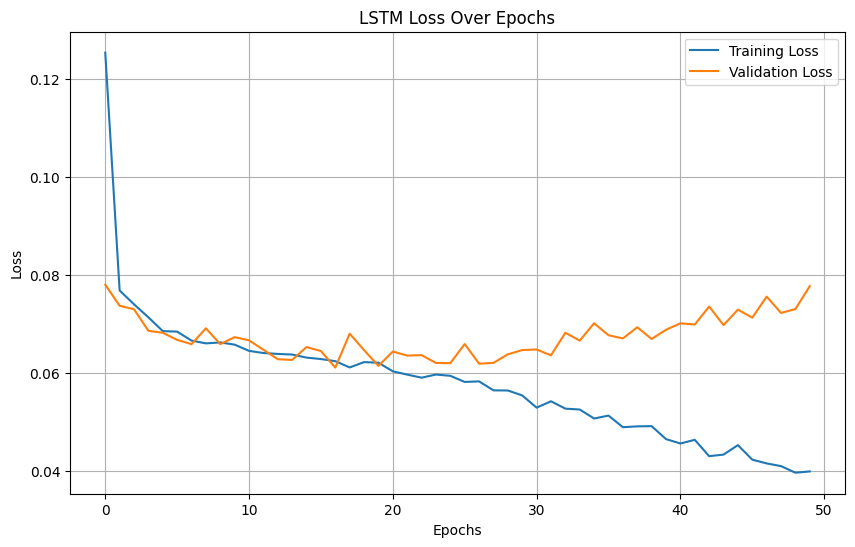

In [109]:
model_loss_plot(history, "LSTM")

#### Make Predictions and Evaluate the Model


In [110]:
lstm_metrics_dict= evaluate_model(lstm_model, X_test, y_test, scaler)
lstm_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


{'MAE': 4.0848641517643145,
 'MSE': 38.63719646658146,
 'RMSE': 6.215882597554547,
 'MAPE': 3526994201928750.0,
 'R² Score': 0.4927346114008031}

In [111]:
# Plot the Actual vs Predicted Results
def plot_actual_vs_predicted(model, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:50], label='Actual')
    plt.plot(y_pred[:50], label='Predicted')
    plt.title(f'Actual vs Predicted Over Time ({model_name})')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Availability Hrs')
    plt.legend()
    plt.grid(True)
    plt.show()


 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


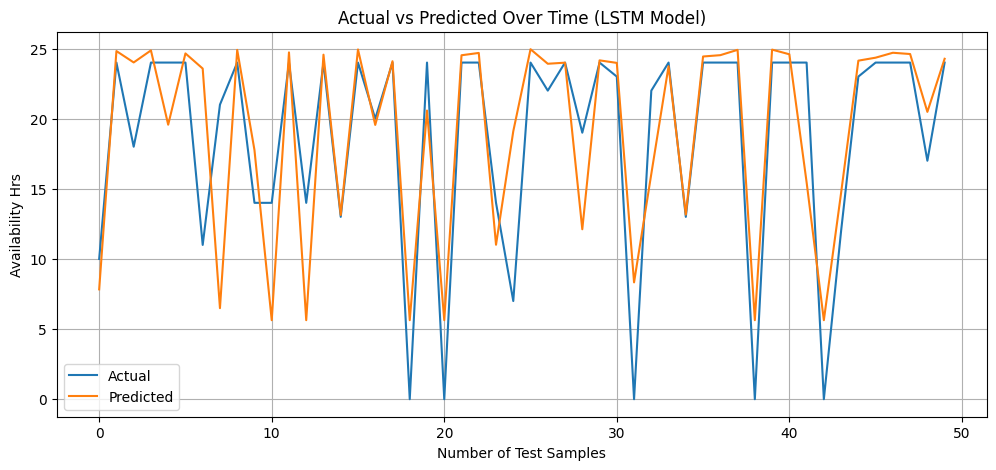

In [112]:
plot_actual_vs_predicted(lstm_model, "LSTM Model")

#### LSTM Tuning With DragonFly Optimisation

In [113]:
domain = [
    (16, 128),      # hidden_units
    (1, 3),         # num_layers
    (0.0, 0.5),     # dropout_rate
    (1e-4, 1e-2),   # learning_rate
    (16, 128)       # batch_size
]

param_names = ["hidden_units", "num_layers", "dropout_rate", "learning_rate", "batch_size"]


In [114]:
# Objective function for Dragonfly
def objective_function(params):
    params= dict(zip(param_names, params))
    print("\n Evaluating with params:", params)
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build LSTM model with given hyperparameters
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(LSTM(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])
    
    # Train the model
    model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 0, epochs=50)
        
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE:", rmse)
    return rmse


In [115]:
# Run Dragonfly optimization
best_val, best_params, history = minimise_function(
    objective_function, domain, max_capital=20
)

best_params_dict = dict(zip(param_names, best_params))
print("Best Parameters:", best_params_dict)
print("Best RMSE:", best_val)

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 20.0 (return_value)

 Evaluating with params: {'hidden_units': np.float64(48.164496243058444), 'num_layers': np.float64(1.5461141671294913), 'dropout_rate': np.float64(0.2936836116105239), 'learning_rate': np.float64(0.0007507237148094572), 'batch_size': np.float64(49.21080813074123)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.38834127825758

 Evaluating with params: {'hidden_units': np.float64(18.719066488105277), 'num_layers': np.float64(2.6683943894366577), 'dropout_rate': np.float64(0.3843053298364782), 'learning_rate': np.float64(0.005850870657531147), 'batch_size': np.float64(29.52558155877261)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.756690761906467

 Evaluating with params: {'hidden_units': np.float64(70.82754100429028), 'num_layers': np.float64(1.9741401919501032), 'dropout_rate': np.float64(0.43559561040732914), 'learning_rate': np.float64(0.009932692789815902), 'batch_size': np.float64(117.36675963714889)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.723525514200913

 Evaluating with params: {'hidden_units': np.float64(100.08906306456133), 'num_layers': np.float64(2.5581033436015828), 'dropout_rate': np.float64(0.06072317021142263), 'learning_rate': np.float64(0.007711415707242768), 'batch_size': np.float64(75.42113624277336)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
RMSE: 6.247874209725046

 Evaluating with params: {'hidden_units': np.float64(124.44474682704937), 'num_layers': np.float64(1.3084412460699113), 'dropout_rate': np.float64(0.1310606248957987), 'learning_rate': np.float64(0.0029531258404730688), 'batch_size': np.float64(84.50269069186393)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 5.357467073930728
Capital spent on initialisation: 5.0000(0.2500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.125), 'learning_rate': np.float64(0.005050000000000001), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.925981607206008


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(117.5), 'num_layers': np.float64(1.375), 'dropout_rate': np.float64(0.15625), 'learning_rate': np.float64(0.00319375), 'batch_size': np.float64(93.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.47081486026408


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(22.125), 'num_layers': np.float64(1.03125), 'dropout_rate': np.float64(0.1171875), 'learning_rate': np.float64(0.005204687500000001), 'batch_size': np.float64(17.75)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.688384182219315


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(79.0), 'num_layers': np.float64(1.375), 'dropout_rate': np.float64(0.28125), 'learning_rate': np.float64(0.00195625), 'batch_size': np.float64(58.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 5.458189477972614


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(127.986328125), 'num_layers': np.float64(1.000244140625), 'dropout_rate': np.float64(0.49993896484375), 'learning_rate': np.float64(0.00010120849609375001), 'batch_size': np.float64(16.013671875)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.425604885630407


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(123.734375), 'num_layers': np.float64(1.0625), 'dropout_rate': np.float64(0.294921875), 'learning_rate': np.float64(0.000409375), 'batch_size': np.float64(124.5)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.418278591543287


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.25), 'dropout_rate': np.float64(0.3125), 'learning_rate': np.float64(0.0013375000000000001), 'batch_size': np.float64(30.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 5.442083707279392
#013 (011, 0.550):: curr_max=-5.35747, acqs=[ei:1, ucb:1, ttei:2, add_ucb:2], 


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(16.0546875), 'num_layers': np.float64(1.0009765625), 'dropout_rate': np.float64(0.000244140625), 'learning_rate': np.float64(0.009995166015625001), 'batch_size': np.float64(127.9453125)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.327247924058629


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(121.0), 'num_layers': np.float64(1.375), 'dropout_rate': np.float64(0.29676008224487305), 'learning_rate': np.float64(0.0010281250000000002), 'batch_size': np.float64(79.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.366114724455212


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(114.0), 'num_layers': np.float64(1.25), 'dropout_rate': np.float64(0.1875), 'learning_rate': np.float64(0.0038125000000000004), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.613410468487306


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(71.9453125), 'num_layers': np.float64(1.0009765625), 'dropout_rate': np.float64(0.499755859375), 'learning_rate': np.float64(0.000104833984375), 'batch_size': np.float64(127.9453125)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.579325415278041


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(126.25), 'num_layers': np.float64(2.96875), 'dropout_rate': np.float64(0.2578125), 'learning_rate': np.float64(0.0008734375000000001), 'batch_size': np.float64(124.5)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 5.300371876222458


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(71.125), 'num_layers': np.float64(2.515625), 'dropout_rate': np.float64(0.25390625), 'learning_rate': np.float64(0.0007960937500000001), 'batch_size': np.float64(99.125)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.341543585126605


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(127.125), 'num_layers': np.float64(2.99609375), 'dropout_rate': np.float64(0.00390625), 'learning_rate': np.float64(0.0019175781250000002), 'batch_size': np.float64(127.78125)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 5.4674186551917945


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(37.0), 'num_layers': np.float64(1.125), 'dropout_rate': np.float64(0.40625), 'learning_rate': np.float64(0.0007187500000000001), 'batch_size': np.float64(86.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.381188537814863


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(2.75), 'dropout_rate': np.float64(0.4375), 'learning_rate': np.float64(0.0087625), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 6.126807302912917
#022 (021, 1.050):: curr_max=-5.30037, acqs=[ei:2, ucb:5, ttei:4, add_ucb:5], 
Best Parameters: {'hidden_units': np.float64(126.25), 'num_layers': np.float64(2.96875), 'dropout_rate': np.float64(0.2578125), 'learning_rate': np.float64(0.0008734375000000001), 'batch_size': np.float64(124.5)}
Best RMSE: 5.300371876222458


In [116]:
best_params_dict

{'hidden_units': np.float64(126.25),
 'num_layers': np.float64(2.96875),
 'dropout_rate': np.float64(0.2578125),
 'learning_rate': np.float64(0.0008734375000000001),
 'batch_size': np.float64(124.5)}

In [117]:
# Retrain LSTM model with Any Optimiser best_param_dicts

def train_best_lstm_model(params, Optimiser_name="Dragonfly"):
    """
    Args:
    Param: params: dict of best hyperparameters from optimiser,
    Optimiser_name: name of the optimiser (for printing)
       
    Return: trained model and training history"""
    
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build LSTM model with given hyperparameters
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(LSTM(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])

    print(f"{Optimiser_name} Model Architecture:")
    model.summary()
    
    # Train the model
    print(f"\n Training {Optimiser_name} Model with best hyperparameters...")
    history = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 1, epochs=50)
    
    return model, history

In [118]:
# Retrain model with the Dragonfly best parameters
dragonfly_lstm_model, dragonfly_history = train_best_lstm_model(best_params_dict, "Dragonfly")

Dragonfly Model Architecture:


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 7, 126)         │        67,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 126)            │       127,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │         2,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,097 (769.91 KB)

 Trainable params: 197,097 (769.91 KB)

 Non-trainable params: 0 (0.00 B)


 Training Dragonfly Model with best hyperparameters...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.4728 - root_mean_squared_error: 0.4604 - val_loss: 0.2423 - val_root_mean_squared_error: 0.2735
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2340 - root_mean_squared_error: 0.2951 - val_loss: 0.1706 - val_root_mean_squared_error: 0.2722
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1719 - root_mean_squared_error: 0.2949 - val_loss: 0.1312 - val_root_mean_squared_error: 0.2732
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1336 - root_mean_squared_error: 0.2891 - val_loss: 0.1079 - val_root_mean_squared_error: 0.2717
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1133 - root_mean_squared_error: 0.2880 - val_loss: 0.0926 - val_root_mean_squared_error: 0.2665
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1008 - root_mean_squared_error: 0.2851 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2650
Ep

In [119]:
lstm_metrics_dict

{'MAE': 4.0848641517643145,
 'MSE': 38.63719646658146,
 'RMSE': 6.215882597554547,
 'MAPE': 3526994201928750.0,
 'R² Score': 0.4927346114008031}

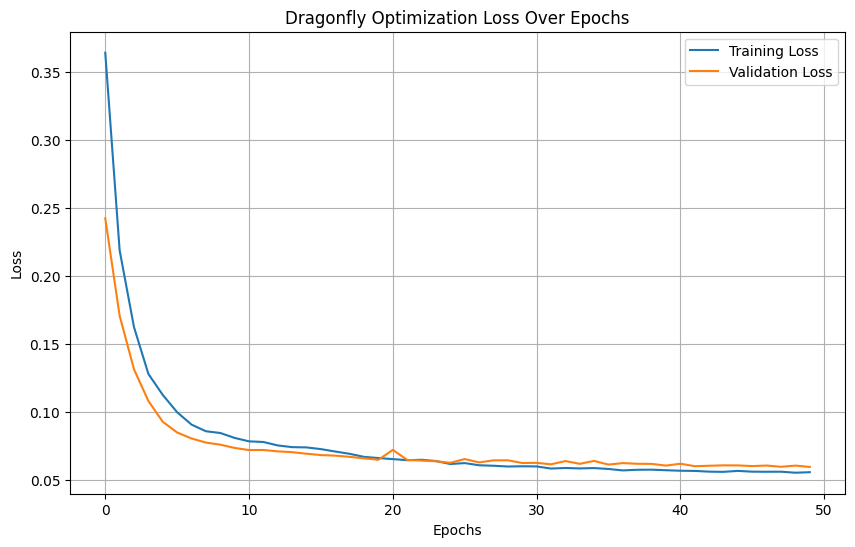

In [120]:
model_loss_plot(dragonfly_history, "Dragonfly Optimization")

In [121]:
# Evaluate the Dragonfly model
dragonfly_lstm_metrics_dict = evaluate_model(dragonfly_lstm_model, X_test, y_test, scaler)
dragonfly_lstm_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


{'MAE': 3.9027872852895453,
 'MSE': 28.839834660497782,
 'RMSE': 5.370273238904868,
 'MAPE': 2890717633394390.5,
 'R² Score': 0.6213635751536095}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


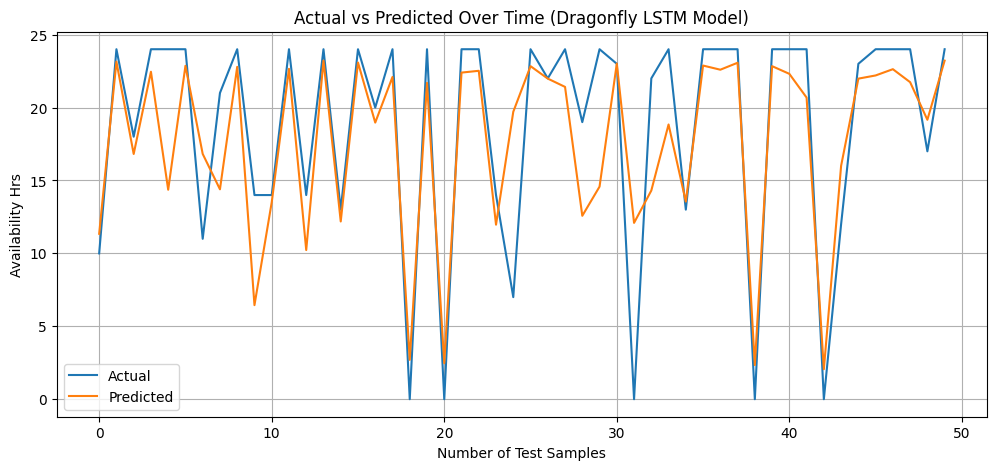

In [122]:
plot_actual_vs_predicted(dragonfly_lstm_model, "Dragonfly LSTM Model")

####  LSTM Hyperparameter Tuning (HyperBand Kerastuner)

In [123]:
def create_lstm_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation= hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model


In [124]:
tuning_base_path = os.path.join('..', 'tuning_params')
if not os.path.exists(tuning_base_path):
    os.makedirs(tuning_base_path)

In [125]:
# Hyperparameter tuning for LSTM
tuner_lstm = kt.Hyperband(
    create_lstm_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory=os.path.join(tuning_base_path, 'lstm_tuning'),
    project_name='lstm_hyperparameter_tuning'
)
batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64])

# Perform the hyperparameter search for GRU
tuner_lstm.search(X_train, y_train, epochs=50, validation_split= 0.1, 
                  batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_lstm_hp = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM Hyperparameters:", best_lstm_hp.values)

Reloading Tuner from ..\tuning_params\lstm_tuning\lstm_hyperparameter_tuning\tuner0.json
Best LSTM Hyperparameters: {'units': 64, 'activation': 'relu', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0009105451871123885, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


In [126]:
# Build the best GRU model
best_lstm_model = tuner_lstm.hypermodel.build(best_lstm_hp)
best_lstm_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 7, 64)          │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,513 (205.13 KB)

 Trainable params: 52,513 (205.13 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
# Fit the best GRU model
history_lstm = best_lstm_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2055 - mae: 0.3614 - val_loss: 0.0782 - val_mae: 0.2291
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0976 - mae: 0.2500 - val_loss: 0.0745 - val_mae: 0.2126
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0868 - mae: 0.2342 - val_loss: 0.0700 - val_mae: 0.1912
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0831 - mae: 0.2307 - val_loss: 0.0698 - val_mae: 0.1929
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0744 - mae: 0.2160 - val_loss: 0.0706 - val_mae: 0.2092
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0762 - mae: 0.2170 - val_loss: 0.0683 - val_mae: 0.1940
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0712 - mae: 0.2102 - val_loss: 0.0669 - val_mae: 0.1946
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0684 - mae: 0.2045 - val_loss: 0.0675 - val_mae: 0.1807
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step 

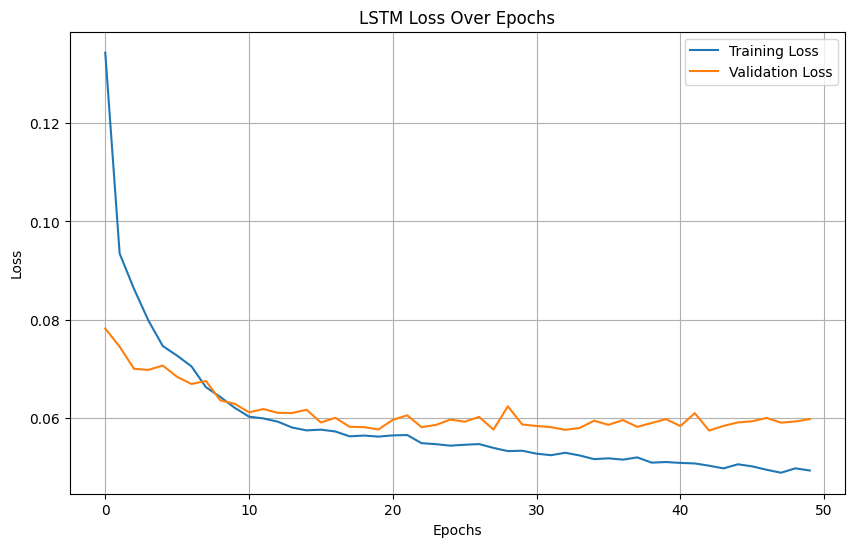

In [128]:
model_loss_plot(history_lstm, "LSTM")

In [129]:
lstm_best_metrics_dict= evaluate_model(best_lstm_model, X_test, y_test, scaler)
lstm_best_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


{'MAE': 3.7722587490779356,
 'MSE': 28.978803600952723,
 'RMSE': 5.383196411143914,
 'MAPE': 2235315793156474.8,
 'R² Score': 0.619539060436449}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


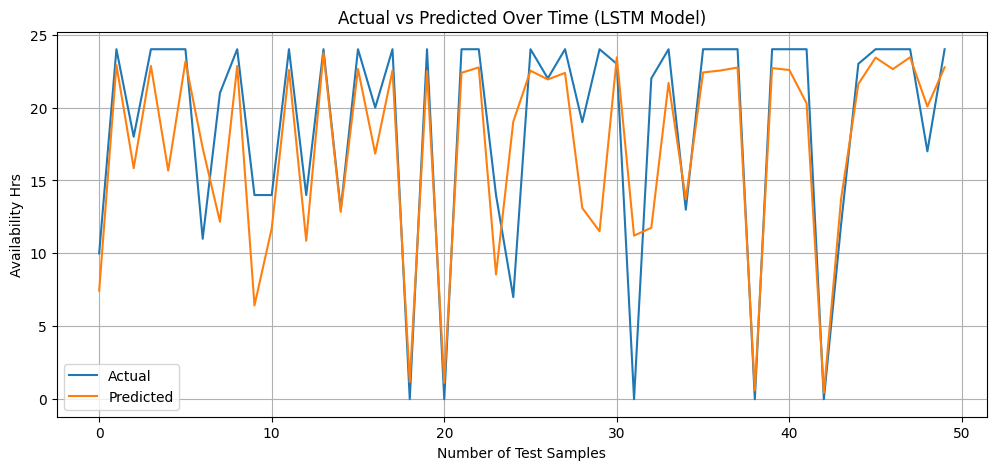

In [130]:
plot_actual_vs_predicted(best_lstm_model, "LSTM Model")

#### Hyperparamters Tuning with Optuna

In [131]:
# import optuna

# def objective_optuna(trial):
#     # Suggest hyperparameters
#     hidden_units = trial.suggest_int("hidden_units", 16, 128)
#     num_layers = trial.suggest_int("num_layers", 1, 3)
#     dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
#     batch_size = trial.suggest_int("batch_size", 16, 128)

#     # Build model
#     model = Sequential()
#     model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
#     for i in range(1, num_layers):
#         model.add(LSTM(hidden_units, return_sequences=(i < num_layers - 1)))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation="linear"))

#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

#     # Train
#     model.fit(X_train, y_train,
#               epochs=20,
#               batch_size=batch_size,
#               validation_split=0.2,
#               verbose=0)

#     # Predict & evaluate
#     y_pred = model.predict(X_test)
#     y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
#     y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     return rmse

# # Run optimisation
# study = optuna.create_study(direction="minimize")
# study.optimize(objective_optuna, n_trials=20)

# print("Best Params:", study.best_trial.params)
# print("Best RMSE:", study.best_trial.value)

In [132]:
# import optuna

# def objective_optuna(trial):
#     """
#     Fixed Optuna objective function with proper error handling
#     """
#     try:
#         # Suggest hyperparameters with proper constraints
#         hidden_units = trial.suggest_int("hidden_units", 16, 128, step=16)
#         num_layers = trial.suggest_int("num_layers", 1, 3)
#         dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
#         learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Changed from loguniform
#         batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])  # Use categorical instead of int

#         print(f"Trial {trial.number}: hidden_units={hidden_units}, num_layers={num_layers}, "
#               f"dropout_rate={dropout_rate:.4f}, learning_rate={learning_rate:.6f}, batch_size={batch_size}")

#         # Build model with proper architecture
#         model = Sequential()
        
#         # First LSTM layer
#         model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
        
#         # Additional LSTM layers
#         for i in range(1, num_layers):
#             return_sequences = (i < num_layers - 1)
#             model.add(LSTM(hidden_units, return_sequences=return_sequences))
            
#             # Add Dense and Dropout only between LSTM layers, not after each one
#             if i < num_layers - 1:
#                 model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
#                 model.add(Dropout(dropout_rate))
        
#         # Final layers
#         model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
#         model.add(Dropout(dropout_rate))
#         model.add(Dense(1, activation="linear"))

#         # Compile model
#         model.compile(
#             optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0), 
#             loss="mse",
#             metrics=['mae']
#         )

#         # Train with proper validation split
#         history = model.fit(
#             X_train, y_train,
#             epochs=20,
#             batch_size=batch_size,
#             validation_split=0.1,  # Changed from 0.2 to 0.1 for consistency
#             verbose=0
#         )

#         # Predict & evaluate with proper error handling
#         y_pred = model.predict(X_test, verbose=0)
        
#         # Ensure predictions are properly shaped
#         if len(y_pred.shape) > 1:
#             y_pred = y_pred.flatten()
        
#         # Inverse transform with proper shape handling
#         y_pred_reshaped = y_pred.reshape(-1, 1)
#         y_test_reshaped = y_test.reshape(-1, 1)
        
#         y_pred_original = scaler.inverse_transform(y_pred_reshaped).flatten()
#         y_true_original = scaler.inverse_transform(y_test_reshaped).flatten()
        
#         # Calculate RMSE with error checking
#         rmse = float(np.sqrt(mean_squared_error(y_true_original, y_pred_original)))
        
#         print(f"Trial {trial.number} RMSE: {rmse:.4f}")
        
#         # Clean up memory
#         del model
#         tf.keras.backend.clear_session()
        
#         # Check for invalid values
#         if np.isnan(rmse) or np.isinf(rmse):
#             print(f"Invalid RMSE value: {rmse}, returning high penalty")

            
#         return rmse
        
#     except Exception as e:
#         print(f"Error in trial {trial.number}: {e}")
#         # Clean up on error
#         tf.keras.backend.clear_session()
#         return 9999.0  # Return high RMSE as penalty

# # Run Optuna optimization with better configuration
# print("Starting Optuna optimization...")
# try:
#     # Create study with better configuration
#     study = optuna.create_study(
#         direction="minimize",
#         sampler=optuna.samplers.TPESampler(seed=42),  # Use TPE sampler with seed
#         pruner=optuna.pruners.MedianPruner()  # Add pruner to stop unpromising trials
#     )
    
#     # Optimize with fewer trials initially to test
#     study.optimize(objective_optuna, n_trials=15, timeout=3600)  # Add timeout
    
#     print("\n" + "="*50)
#     print("OPTUNA OPTIMIZATION COMPLETED")
#     print("="*50)
#     print("Best Params:", study.best_trial.params)
#     print("Best RMSE:", study.best_trial.value)
#     print("Number of finished trials:", len(study.trials))
    
#     # Store results
#     optuna_best_params = study.best_trial.params
#     optuna_best_rmse = study.best_trial.value
    
# except Exception as e:
#     print(f"Error during Optuna optimization: {e}")
#     optuna_best_params = None
#     optuna_best_rmse = None

In [133]:
# lstm_optuna_model, lstm_optuna_history = train_best_lstm_model(study.best_trial.params, "Optuna")

### GRU Model Training

In [134]:
#Build the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add((GRU(32)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [135]:
# Model training and evaluation
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))  # Define input shape
gru_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 128)         │        52,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,705 (268.38 KB)

 Trainable params: 68,705 (268.38 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
history_gru = gru_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)

Epoch 1/50


216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.2336 - root_mean_squared_error: 0.3559 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2714
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0784 - root_mean_squared_error: 0.2690 - val_loss: 0.0675 - val_root_mean_squared_error: 0.2543
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0667 - root_mean_squared_error: 0.2533 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2563
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0611 - root_mean_squared_error: 0.2438 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2539
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0611 - root_mean_squared_error: 0.2440 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2485
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0598 - root_mean_squared_error: 0.2417 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2462
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - lo

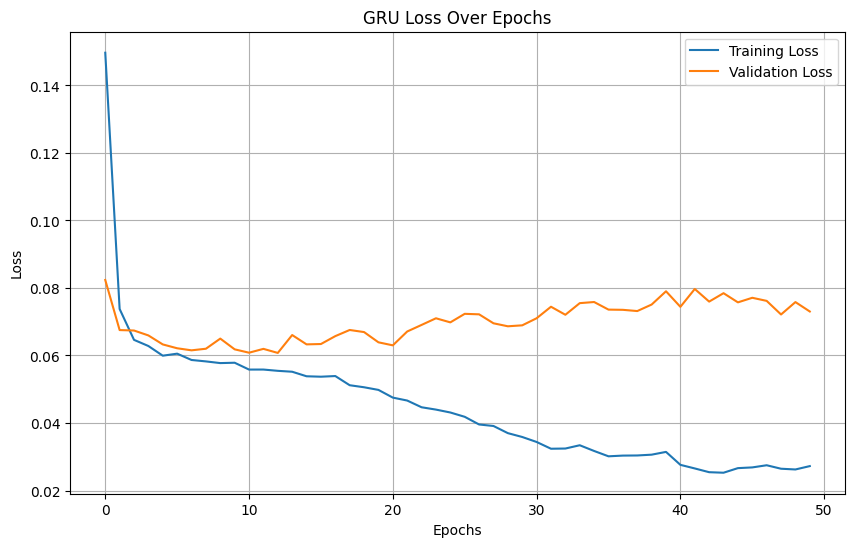

In [137]:
model_loss_plot(history_gru, "GRU")

In [138]:
gru_metrics_dict = evaluate_model(gru_model, X_test, y_test, scaler)
gru_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


{'MAE': 4.25590668041006,
 'MSE': 37.56445064664282,
 'RMSE': 6.128984471072089,
 'MAPE': 2571504091778896.5,
 'R² Score': 0.5068186256405527}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


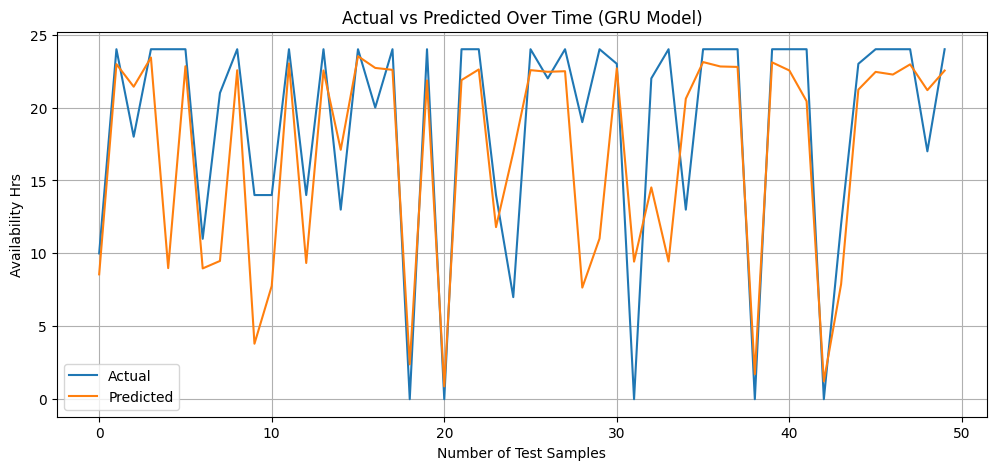

In [139]:
plot_actual_vs_predicted(gru_model, "GRU Model")

In [140]:
# df_comparison_gru = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})

# # Plot Actual vs Predicted for GRU
# plt.figure(figsize=(10, 6))
# plt.plot(df_comparison_gru['Actual'].values, label='Actual Total Energy Deficit')
# plt.plot(df_comparison_gru['Predicted'].values, label='Predicted Total Energy Deficit')
# plt.title('Actual vs Predicted Energy Deficit - GRU')
# plt.xlabel('Time Step')
# plt.ylabel('Total Energy Deficit')
# plt.legend()
# plt.grid(True)
# plt.show()

#### GRU Hyperparamters Tuning with DragonFly Optimisation

In [141]:
# Objective function for Dragonfly
def objective_function(params):
    params= dict(zip(param_names, params))
    print("\n Evaluating with params:", params)
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build GRU model with given hyperparameters
    model = Sequential()
    model.add(GRU(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(GRU(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])
    
    # Train the model
    model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 0, epochs=50)
        
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE:", rmse)
    return rmse


In [142]:
# Run Dragonfly optimization
best_val, best_gru_params, history = minimise_function(
    objective_function, domain, max_capital=20
)

best_params_dict = dict(zip(param_names, best_gru_params))
print("Best Parameters:", best_params_dict)
print("Best RMSE:", best_val)

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 20.0 (return_value)

 Evaluating with params: {'hidden_units': np.float64(106.56003902859717), 'num_layers': np.float64(1.6137327778762645), 'dropout_rate': np.float64(0.14510213814171607), 'learning_rate': np.float64(0.008697132490473087), 'batch_size': np.float64(102.29993608418368)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 6.580848651931222

 Evaluating with params: {'hidden_units': np.float64(101.64876985089009), 'num_layers': np.float64(2.7132757793692637), 'dropout_rate': np.float64(0.03634585321995686), 'learning_rate': np.float64(0.0035662601010166), 'batch_size': np.float64(51.869497171026076)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 6.199450947347359

 Evaluating with params: {'hidden_units': np.float64(64.6357562120038), 'num_layers': np.float64(1.345676581500049), 'dropout_rate': np.float64(0.47316218333041166), 'learning_rate': np.float64(0.00665441706244185), 'batch_size': np.float64(115.05560767486634)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 6.008961974819983

 Evaluating with params: {'hidden_units': np.float64(54.99236490091475), 'num_layers': np.float64(2.263243004941879), 'dropout_rate': np.float64(0.39321110700809797), 'learning_rate': np.float64(0.0018475013869424478), 'batch_size': np.float64(79.51608983926933)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.491471412826237

 Evaluating with params: {'hidden_units': np.float64(33.70321548206776), 'num_layers': np.float64(2.1085962665521496), 'dropout_rate': np.float64(0.21809668490192496), 'learning_rate': np.float64(0.005245466699724924), 'batch_size': np.float64(19.674422624794115)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 6.018508677186164
Capital spent on initialisation: 5.0000(0.2500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(19.5), 'num_layers': np.float64(1.96875), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.00017734375), 'batch_size': np.float64(30.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.4260315495344384


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(58.0), 'num_layers': np.float64(2.5), 'dropout_rate': np.float64(0.125), 'learning_rate': np.float64(0.007525000000000001), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.9742209978874845


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.50259738444271


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(47.5), 'num_layers': np.float64(2.1875), 'dropout_rate': np.float64(0.390625), 'learning_rate': np.float64(0.0010281250000000002), 'batch_size': np.float64(75.5)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.403226344813348


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(65.0), 'num_layers': np.float64(2.375), 'dropout_rate': np.float64(0.40625), 'learning_rate': np.float64(0.0013375000000000001), 'batch_size': np.float64(86.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.444749395153685


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(2.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.523838623981162


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(28.25), 'num_layers': np.float64(2.96875), 'dropout_rate': np.float64(0.0078125), 'learning_rate': np.float64(0.00025468750000000003), 'batch_size': np.float64(126.25)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 5.392023413585712
#013 (011, 0.550):: curr_max=-5.40323, acqs=[ei:3, ucb:1, ttei:1, add_ucb:1], 


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(2.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.484364889164185


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(23.0), 'num_layers': np.float64(1.125), 'dropout_rate': np.float64(0.46875), 'learning_rate': np.float64(0.00938125), 'batch_size': np.float64(121.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.929386674843353


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(16.02734375), 'num_layers': np.float64(2.99609375), 'dropout_rate': np.float64(0.44415283203125), 'learning_rate': np.float64(0.0001193359375), 'batch_size': np.float64(127.5625)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.741958419090061


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(2.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.407106164541969


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(45.75), 'num_layers': np.float64(2.96875), 'dropout_rate': np.float64(0.0078125), 'learning_rate': np.float64(0.00025468750000000003), 'batch_size': np.float64(115.75)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 5.438856367202638


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.25), 'dropout_rate': np.float64(0.0625), 'learning_rate': np.float64(0.0013375000000000001), 'batch_size': np.float64(86.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.3590949348203845


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(40.5), 'num_layers': np.float64(1.125), 'dropout_rate': np.float64(0.00048828125), 'learning_rate': np.float64(0.00010966796875000001), 'batch_size': np.float64(82.5)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.507581623988229


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(101.75), 'num_layers': np.float64(2.96875), 'dropout_rate': np.float64(0.0078125), 'learning_rate': np.float64(0.0014921875000000002), 'batch_size': np.float64(126.25)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.299592725676039


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(51.0), 'num_layers': np.float64(2.220592498779297), 'dropout_rate': np.float64(0.40625), 'learning_rate': np.float64(0.005668750000000001), 'batch_size': np.float64(93.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.835194058945587
#022 (021, 1.050):: curr_max=-5.29959, acqs=[ei:7, ucb:3, ttei:2, add_ucb:4], 
Best Parameters: {'hidden_units': np.float64(101.75), 'num_layers': np.float64(2.96875), 'dropout_rate': np.float64(0.0078125), 'learning_rate': np.float64(0.0014921875000000002), 'batch_size': np.float64(126.25)}
Best RMSE: 5.299592725676039


#### GRU Hyperparamters Tuning

In [143]:
def create_gru_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(GRU(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation= hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model


In [144]:
# Hyperparameter tuning for GRU
tuner_gru = kt.Hyperband(
    create_gru_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory=os.path.join(tuning_base_path,'gru_tuning'),
    project_name='gru_hyperparameter_tuning'
)

# Perform the hyperparameter search for GRU
tuner_gru.search(X_train, y_train, epochs=50, 
                 validation_split= 0.1, 
                 batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_gru_hp = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
print("Best GRU Hyperparameters:", best_gru_hp.values)

Reloading Tuner from ..\tuning_params\gru_tuning\gru_hyperparameter_tuning\tuner0.json
Best GRU Hyperparameters: {'units': 96, 'activation': 'tanh', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0008367811950596679, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [145]:
# Build the best GRU model
best_gru_model = tuner_gru.hypermodel.build(best_gru_hp)
best_gru_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_37 (GRU)                    │ (None, 7, 96)          │        30,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_38 (GRU)                    │ (None, 96)             │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,681 (342.50 KB)

 Trainable params: 87,681 (342.50 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
# Fit the best GRU model
history_gru = best_gru_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1461 - mae: 0.3026 - val_loss: 0.0794 - val_mae: 0.2020
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0856 - mae: 0.2331 - val_loss: 0.0675 - val_mae: 0.1901
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0771 - mae: 0.2178 - val_loss: 0.0642 - val_mae: 0.1778
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0727 - mae: 0.2115 - val_loss: 0.0647 - val_mae: 0.1882
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0677 - mae: 0.2028 - val_loss: 0.0638 - val_mae: 0.1840
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0646 - mae: 0.1986 - val_loss: 0.0638 - val_mae: 0.1844
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0664 - mae: 0.1987 - val_loss: 0.0634 - val_mae: 0.1794
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0618 - mae: 0.1932 - val_loss: 0.0626 - val_mae: 0.1714
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/s

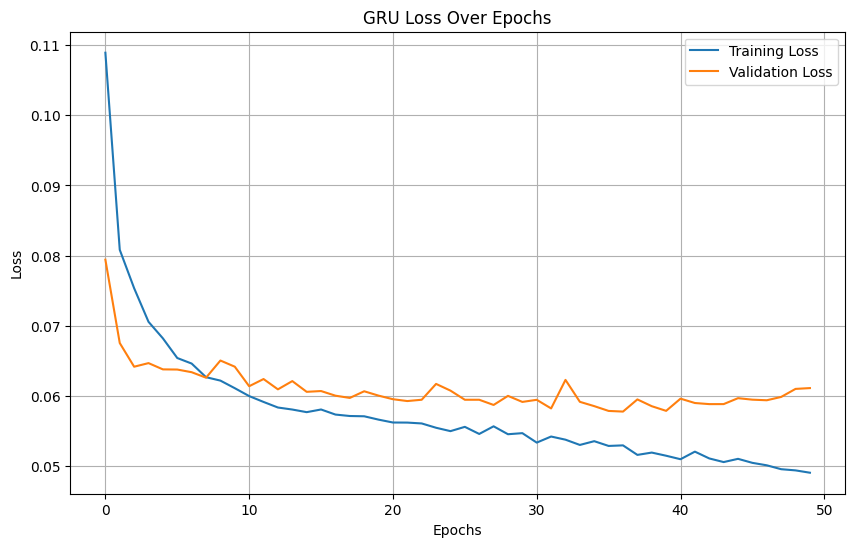

In [147]:
model_loss_plot(history_gru, "GRU")

In [148]:
gru_best_metrics_dict = evaluate_model(best_gru_model, X_test, y_test, scaler)
gru_best_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


{'MAE': 4.098295590969712,
 'MSE': 29.893621828995347,
 'RMSE': 5.467505997161352,
 'MAPE': 2446769391828410.0,
 'R² Score': 0.6075284678887458}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


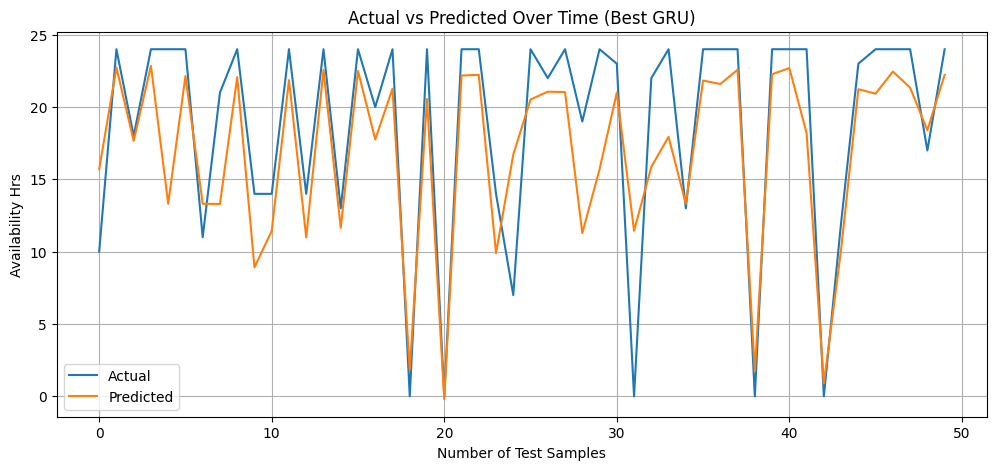

In [149]:
plot_actual_vs_predicted(best_gru_model, "Best GRU")

### BiLSTM Model Training

In [150]:
#Build the Bidirectional LSTM(model
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add((Bidirectional(LSTM(32))))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [151]:
# Model training and evaluation
bilstm_model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))  # Define input shape
bilstm_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [152]:
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.2109 - root_mean_squared_error: 0.3348 - val_loss: 0.0825 - val_root_mean_squared_error: 0.2821
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0776 - root_mean_squared_error: 0.2738 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2706
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0726 - root_mean_squared_error: 0.2670 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2686
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0698 - root_mean_squared_error: 0.2615 - val_loss: 0.0689 - val_root_mean_squared_error: 0.2604
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0656 - root_mean_squared_error: 0.2537 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2604
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0663 - root_mean_squared_error: 0.2552 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2567
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13

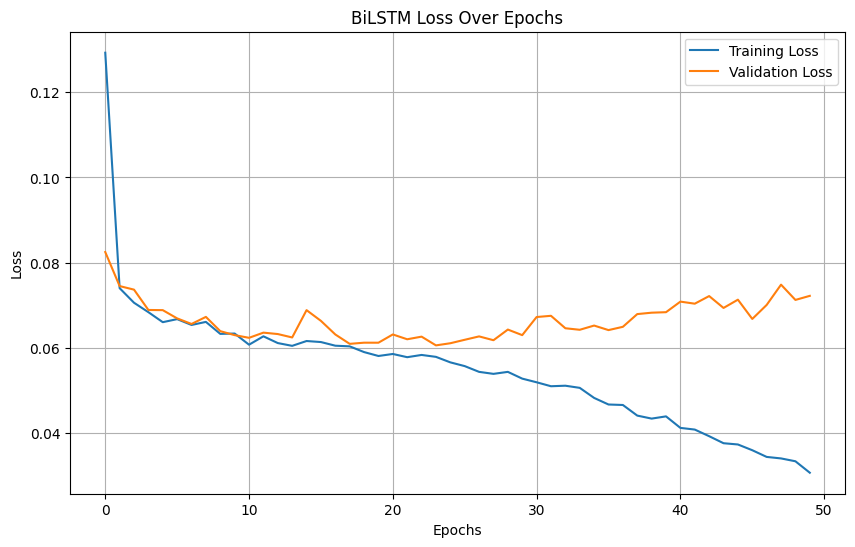

In [153]:
model_loss_plot(history_bilstm, "BiLSTM")

In [154]:
bilstm_metrics_dict= evaluate_model(bilstm_model, X_test, y_test, scaler)
bilstm_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


{'MAE': 4.20838627969708,
 'MSE': 38.04576822700009,
 'RMSE': 6.168125179258288,
 'MAPE': 2963261322419650.5,
 'R² Score': 0.500499436574888}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


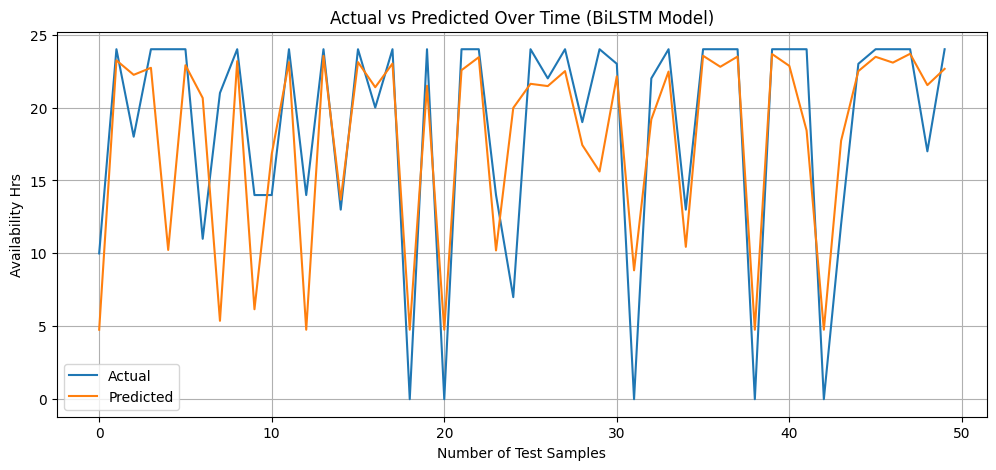

In [155]:
plot_actual_vs_predicted(bilstm_model, "BiLSTM Model")

#### BiLSTM Hyperparamter Tuning

In [156]:
def create_bilstm_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(Bidirectional(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
            return_sequences=True
        ),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    
    model.add(Bidirectional(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        )
    ))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model

In [157]:
# Hyperparameter tuning for BiLSTM
tuner_bilstm = kt.Hyperband(
    create_bilstm_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory= os.path.join(tuning_base_path, 'bilstm_tuning'),
    project_name='bilstm_hyperparameter_tuning'
)

# Perform the hyperparameter search for BiLSTM
tuner_bilstm.search(X_train, y_train, epochs=50, validation_split=0.1, 
                    batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_bilstm_hp = tuner_bilstm.get_best_hyperparameters(num_trials=1)[0]
print("Best BiLSTM Hyperparameters:", best_bilstm_hp.values)



Reloading Tuner from ..\tuning_params\bilstm_tuning\bilstm_hyperparameter_tuning\tuner0.json
Best BiLSTM Hyperparameters: {'units': 128, 'activation': 'relu', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001325242185767969, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [158]:
# Build the best BiLSTM model
best_bilstm_model = tuner_bilstm.hypermodel.build(best_bilstm_hp)
best_bilstm_model.summary()


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 7, 256)         │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,633 (2.05 MB)

 Trainable params: 537,633 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
# Fit the best BiLSTM model
history_bilstm = best_bilstm_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)


Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.2931 - mae: 0.4425 - val_loss: 0.0743 - val_mae: 0.2149
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0984 - mae: 0.2509 - val_loss: 0.0727 - val_mae: 0.2117
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0936 - mae: 0.2451 - val_loss: 0.0733 - val_mae: 0.2145
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0915 - mae: 0.2406 - val_loss: 0.0693 - val_mae: 0.1820
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0912 - mae: 0.2403 - val_loss: 0.0717 - val_mae: 0.2123
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0880 - mae: 0.2352 - val_loss: 0.0683 - val_mae: 0.1935
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0863 - mae: 0.2322 - val_loss: 0.0697 - val_mae: 0.2047
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0869 - mae: 0.2325 - val_loss: 0.0841 - val_mae: 0.2463
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms

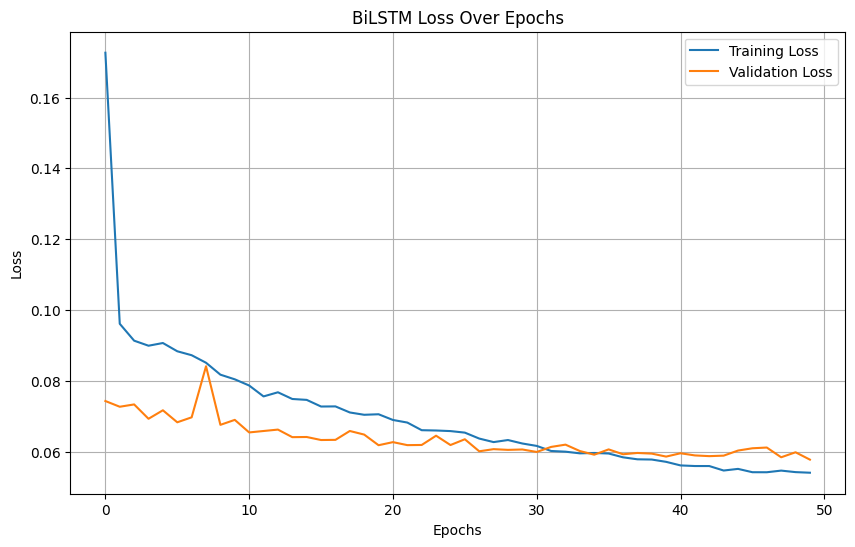

In [160]:
model_loss_plot(history_bilstm, "BiLSTM")

In [161]:
bilstm_best_metrics_dict= evaluate_model(best_bilstm_model, X_test, y_test, scaler)
bilstm_best_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


{'MAE': 3.816355617691606,
 'MSE': 28.93027010484367,
 'RMSE': 5.378686652412806,
 'MAPE': 2305683708746535.0,
 'R² Score': 0.620176253737602}

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


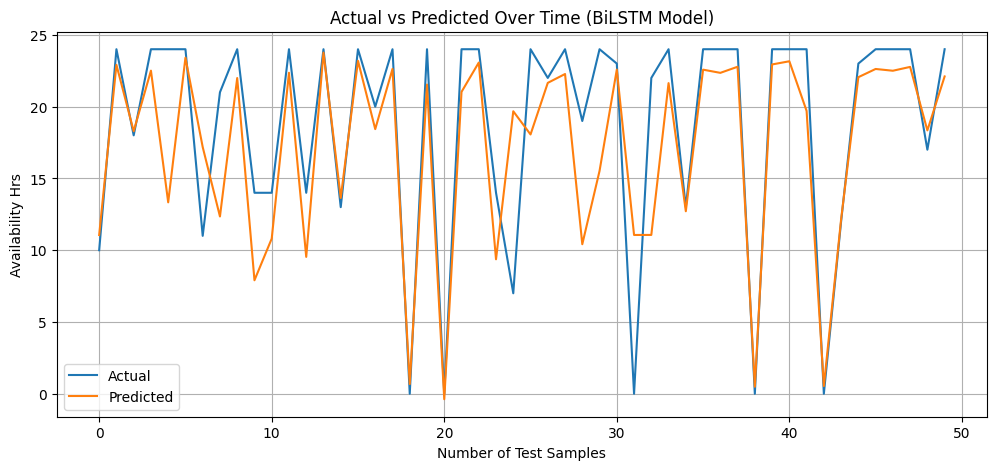

In [162]:
plot_actual_vs_predicted(best_bilstm_model, "BiLSTM Model")

### Model Comparison

In [163]:
#Create a dataframe to compare all models' metrics
model_metrics= {
    "Linear Regression": lr_metrics_dict,
    "XGBoost": xgb_metrics_dict,
    "LSTM": lstm_metrics_dict,
    "GRU": gru_metrics_dict,
    "BiLSTM": bilstm_metrics_dict
}

metrics_df= pd.DataFrame(model_metrics).T
metrics_df


,MAE,MSE,RMSE,MAPE,R² Score
Linear Regression,3.908199,27.195787,5.214958,1.783361e+15,0.637234
XGBoost,1.643294,7.444758,2.728508,2.580198e+14,0.900694
LSTM,4.084864,38.637196,6.215883,3.526994e+15,0.492735
GRU,4.255907,37.564451,6.128984,2.571504e+15,0.506819
BiLSTM,4.208386,38.045768,6.168125,2.963261e+15,0.500499


In [164]:
#Create a dataframe to compare all models' metrics
best_model_metrics= {
    "LSTM": lstm_best_metrics_dict,
    "GRU": gru_best_metrics_dict,
    "BiLSTM": bilstm_best_metrics_dict
}

best_metrics_df= pd.DataFrame(best_model_metrics).T
best_metrics_df

,MAE,MSE,RMSE,MAPE,R² Score
LSTM,3.772259,28.978804,5.383196,2.235316e+15,0.619539
GRU,4.098296,29.893622,5.467506,2.446769e+15,0.607528
BiLSTM,3.816356,28.930270,5.378687,2.305684e+15,0.620176


In [165]:
metrics_base_path = os.path.join('..', 'model_metrics')
if not os.path.exists(metrics_base_path):
    os.makedirs(metrics_base_path)

metrics_df.to_csv(os.path.join(metrics_base_path, 'model_metrics_comparison.csv'))
best_metrics_df.to_csv(os.path.join(metrics_base_path, 'best_model_metrics.csv'))

In [166]:
#Group the metrics by desecnding order of RMSE
metrics_df_sorted = metrics_df.sort_values(by='MSE', ascending=True)
metrics_df_sorted

,MAE,MSE,RMSE,MAPE,R² Score
XGBoost,1.643294,7.444758,2.728508,2.580198e+14,0.900694
Linear Regression,3.908199,27.195787,5.214958,1.783361e+15,0.637234
GRU,4.255907,37.564451,6.128984,2.571504e+15,0.506819
BiLSTM,4.208386,38.045768,6.168125,2.963261e+15,0.500499
LSTM,4.084864,38.637196,6.215883,3.526994e+15,0.492735


In [167]:
#Group the metrics by desecnding order of RMSE
best_metrics_df_sorted = best_metrics_df.sort_values(by='RMSE', ascending=True)
best_metrics_df_sorted.to_csv(os.path.join(metrics_base_path, 'best_model_metrics_sorted.csv'))

In [168]:
# drop MSE from metrics_df
metrics_df = metrics_df.drop(columns=['MSE'])

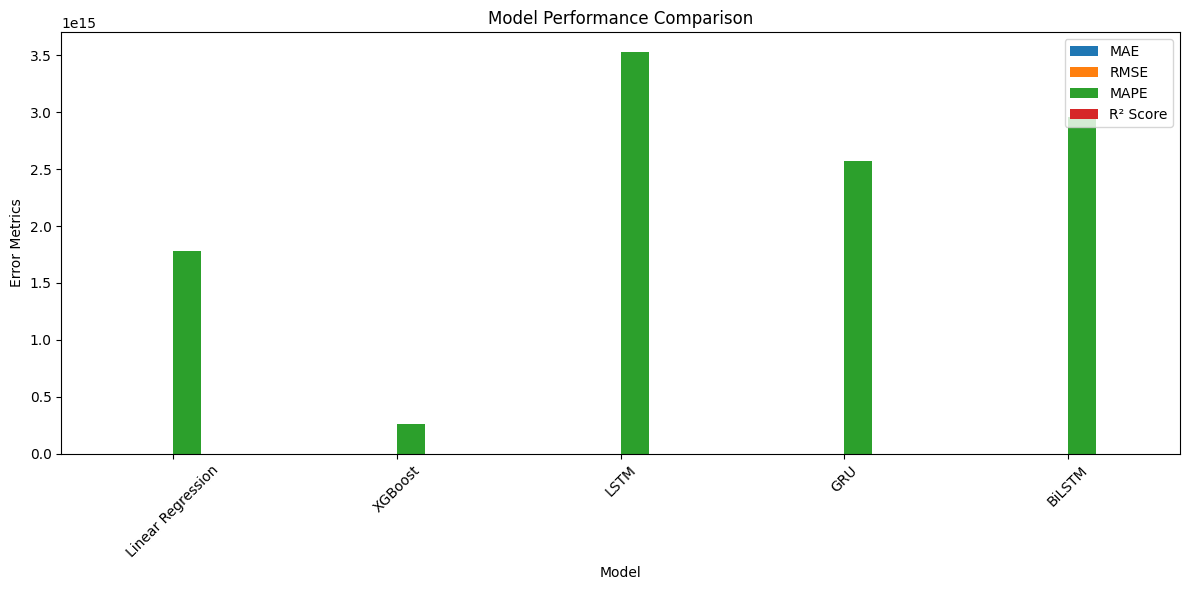

In [169]:
#Plot the metrics
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [170]:
# drop RMSE from best_metrics_df
best_metrics_df.drop(columns=['MSE'], inplace=True)

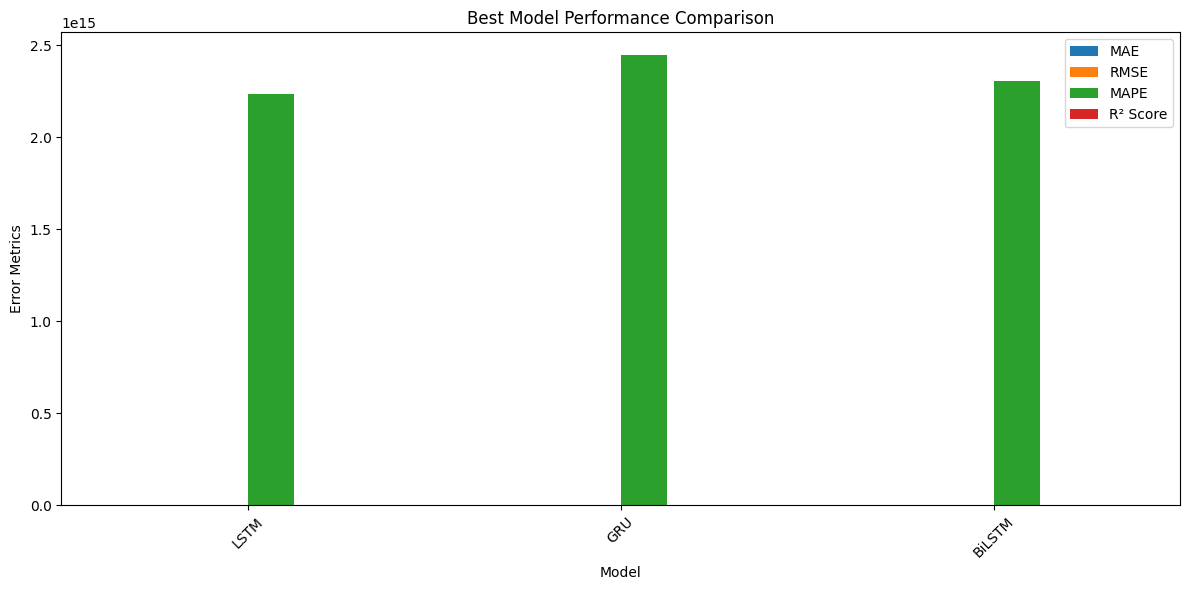

In [171]:
#Plot the best metrics
best_metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Best Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Save the Best Model

In [172]:
# Save the best model
best_model_name= best_metrics_df_sorted.index[0]
if best_model_name == 'LSTM':
    best_model = best_lstm_model
elif best_model_name == 'GRU':
    best_model = best_gru_model
elif best_model_name == 'BiLSTM':
    best_model = best_bilstm_model
else:
    raise ValueError("Unknown best model name")

In [173]:
# Save and dump best model using a valid Keras extension
best_model_path = os.path.join(metrics_base_path, f'{best_model_name}_model.keras')
best_model.save(best_model_path)